<a href="https://colab.research.google.com/github/PedroJesusBenito/Detecci-n-de-transacciones-fraudulentas/blob/main/Detecci%C3%B3n_de_transacciones_fraudulentas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comenzamos montando Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importamos algunas bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Cargamos el DataSet usando la columna "id" como index ya que si mantenemos el índice que genera pandas podríamos eliminar esta columna porque no aportaría nada nuevo

In [3]:
file= "/content/drive/MyDrive/Data Sets/creditcard_2023.csv"
df= pd.read_csv(file, index_col="id")

Comprobamos

In [4]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
id,,,,,,,,,,,,,,,,,,,,,
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


Este conjunto de datos ya está preprocesado, ha sido normalizado y se le ha aplicado pca, por lo que nuestro EDA realmente no será muy extenso. De todos modos y a pesar de que la lógica nos indica que todo problema que haya existido en el DataSet fue corregido antes de preprocesarlo, de todos modos vamos a conducir una pequeña exploración para confirmar que no haya nada que haya quedado sin resolver.


Buscaremos duplicados y valores faltantes

In [5]:
df.duplicated().sum()

1

In [6]:
df.isna().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Ahora vamos a revisar el equilibrio de las clases de nuestra columnna objetivo

In [7]:
df["Class"].value_counts()

0    284315
1    284315
Name: Class, dtype: int64

Podemos que tenemos un conjunto de datos perfectamente balanceado, exactamente la misma cantidad de datos para clase

Debido a que tenemos colunnas de PCA y no las características orginales, la exploración pierde sentido.


Avancemos entonces a trabajar con nuestros modelos de clasificación

Vamos a cargar algunas bibliotecas

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import set_config
set_config(display="diagram")
from sklearn.decomposition import PCA

In [9]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
id,,,,,,,,,,,,,,,,,,,,,
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


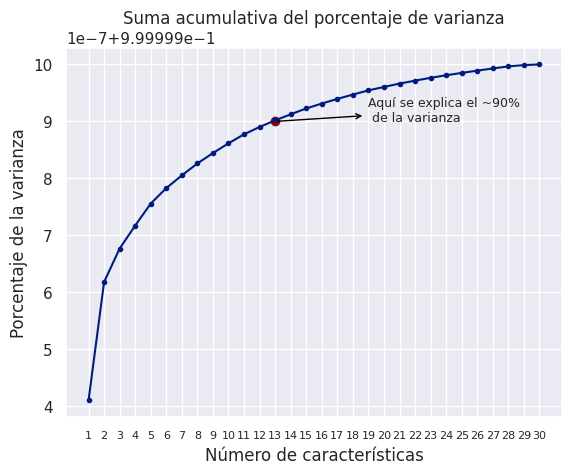

In [10]:
pca = PCA()
pca.fit(df)
sns.set_theme(style="darkgrid", palette="dark")
fig, ax = plt.subplots()
ax.plot(13,0.9999999, 'ro')
ax.annotate("Aquí se explica el ~90% \n de la varianza", xy=(13,0.9999999), xytext=(19,0.9999999), fontsize=9, arrowprops=dict(arrowstyle="<-", color='black'))
plt.plot(range(1, 31), pca.explained_variance_ratio_.cumsum(), marker= '.')
plt.xticks(ticks=range(1,31), fontsize=8)
ax.set_xlabel("Número de características")
ax.set_ylabel("Porcentaje de la varianza")
ax.set_title("Suma acumulativa del porcentaje de varianza")
plt.show();

Ahora separamos nuestros datos en matriz de datos y vector objetivo



In [11]:
X=df.drop(columns="Class")
y=df["Class"]
X_train, X_test, y_train, y_test=train_test_split(X, y,test_size=0.3, stratify=y, random_state=21)
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, test_size=0.66, random_state=21)

Veamos el tamaño de nuestra matriz X

In [12]:
X.shape

(568630, 29)

Como nuestros datos ya están preprocesados, vamos a pasar directamente al proceso de trabajar con nuestros modelos.

Primero lo haremos con todos nuestros datos y luego evaluaremos en términos de métricas y tiempos

In [13]:
logreg = LogisticRegression(solver="newton-cholesky")

logreg.fit(X_train, y_train)

test_preds = logreg.predict(X_test)

test_score = accuracy_score(y_test, test_preds)

print("Reporte de clasificación para Regresor Logístico \n")
print(classification_report(y_test,test_preds))

Reporte de clasificación para Regresor Logístico 

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     29001
           1       0.98      0.95      0.96     28999

    accuracy                           0.96     58000
   macro avg       0.97      0.96      0.96     58000
weighted avg       0.97      0.96      0.96     58000



Ejecución instantánea(7 segundos) y excelentes resultados

Reporte de clasificación para Regresor Logístico

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     29001
           1       0.98      0.95      0.96     28999

    accuracy                            0.96     58000
    macro avg       0.97      0.96      0.96     58000
    weighted avg    0.97      0.96      0.96     58000


In [14]:
dtc = DecisionTreeClassifier(max_depth=9)

dtc.fit(X_train, y_train)

test_preds = dtc.predict(X_test)

test_score = accuracy_score(y_test, test_preds)

print("Reporte de clasificación para DecisionTreeClassifier \n")
print(classification_report(y_test,test_preds))


Reporte de clasificación para DecisionTreeClassifier 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     29001
           1       0.98      0.98      0.98     28999

    accuracy                           0.98     58000
   macro avg       0.98      0.98      0.98     58000
weighted avg       0.98      0.98      0.98     58000



Ejecución en 30 segundos y con resultados casi perfectos

Reporte de clasificación para DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     29001
           1       0.98      0.98      0.98     28999

    accuracy                            0.98     58000
    macro avg       0.98      0.98      0.98     58000   
    weighted avg    0.98      0.98      0.98     58000

In [15]:
#rfc = RandomForestClassifier(n_estimators=700, max_depth=11)

#rfc.fit(X_train, y_train)

#test_preds = rfc.predict(X_test)

#test_score = accuracy_score(y_test, test_preds)

#print("Reporte de clasificación para RandomForestClassifier \n")
#print(classification_report(y_test,test_preds))

Este modelo tiene muy buenos resultados pero tomó 45 minutos ejecutar esta celda.

Los resultados son equivalentes al Decision Tree Classifier per con una diferencia abismal en tiempo de cómputo

In [16]:
rfc = RandomForestClassifier(n_estimators=21, max_depth=7)

rfc.fit(X_train, y_train)

test_preds = rfc.predict(X_test)

test_score = accuracy_score(y_test, test_preds)

print("Reporte de clasificación para RandomForestClassifier \n")
print(classification_report(y_test,test_preds))

Reporte de clasificación para RandomForestClassifier 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29001
           1       1.00      0.94      0.97     28999

    accuracy                           0.97     58000
   macro avg       0.97      0.97      0.97     58000
weighted avg       0.97      0.97      0.97     58000



Este modelo tomó un minuto y 22 segundos

Reporte de clasificación para RandomForestClassifier

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29001
           1       1.00      0.94      0.97     28999

    accuracy                               0.97     58000
    macro avg          0.97      0.97      0.97     58000   
    weighted avg       0.97      0.97      0.97     58000

In [17]:
#svc = SVC()

#svc.fit(X_train, y_train)

#test_preds = svc.predict(X_test)

#test_score = accuracy_score(y_test, test_preds)

#print("Reporte de clasificación para Support Vector Machines \n")
#print(classification_report(y_test,test_preds))

Este modelo tardó 2 horas y 19 minutos en ejecutar, no pudimos botener los resultados porque el entorno de ejecución fue desconectado

In [18]:
knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train, y_train)

test_preds = knn.predict(X_test)

test_score = accuracy_score(y_test, test_preds)

print("Reporte de clasificación para k-Nearest Neighbors \n")
print(classification_report(y_test,test_preds))

Reporte de clasificación para k-Nearest Neighbors 

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     29001
           1       0.99      0.88      0.93     28999

    accuracy                           0.93     58000
   macro avg       0.94      0.93      0.93     58000
weighted avg       0.94      0.93      0.93     58000



Este modelo tardó un par de minutos y sus resultados son los más bajos obtenidos hasta ahora:

Reporte de clasificación para k-Nearest Neighbors

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     29001
           1       0.99      0.88      0.93     28999

    accuracy                               0.93     58000
    macro avg          0.94      0.93      0.93     58000   
    weighted avg       0.94      0.93      0.93     58000

In [19]:
xgbc = xgb.XGBClassifier(n_estimators=432, max_depth=11)

xgbc.fit(X_train, y_train)

test_preds = xgbc.predict(X_test)

test_score = accuracy_score(y_test, test_preds)

print("Reporte de clasificación para Gradient Boosting  \n")
print(classification_report(y_test,test_preds))

Reporte de clasificación para Gradient Boosting  

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29001
           1       1.00      1.00      1.00     28999

    accuracy                           1.00     58000
   macro avg       1.00      1.00      1.00     58000
weighted avg       1.00      1.00      1.00     58000



¡Resultados perfectos en 35 segundos! Esto sí que es un logro tremendo, hemos encontrado el modelo perfecto para este problema.

Reporte de clasificación para Gradient Boosting  

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29001
           1       1.00      1.00      1.00     28999

    accuracy                               1.00     58000
    macro avg          1.00      1.00      1.00     58000
    weighted avg       1.00      1.00      1.00     58000

Ahora vamos a evaluarlo con el set de validación



In [20]:
xgbc = xgb.XGBClassifier(n_estimators=432, max_depth=11)

xgbc.fit(X_train, y_train)

val_preds = xgbc.predict(X_val)

val_score = accuracy_score(y_val, val_preds)

print("Reporte de clasificación para Gradient Boosting  \n")
print(classification_report(y_val,val_preds))

Reporte de clasificación para Gradient Boosting  

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56293
           1       1.00      1.00      1.00     56296

    accuracy                           1.00    112589
   macro avg       1.00      1.00      1.00    112589
weighted avg       1.00      1.00      1.00    112589



56 segundos de ejecución y otro resultado perfecto.

Tenemos en nuestras manos el modelo perfecto para detectar fraudes bancarios con la información proporcionada en este DataSet.

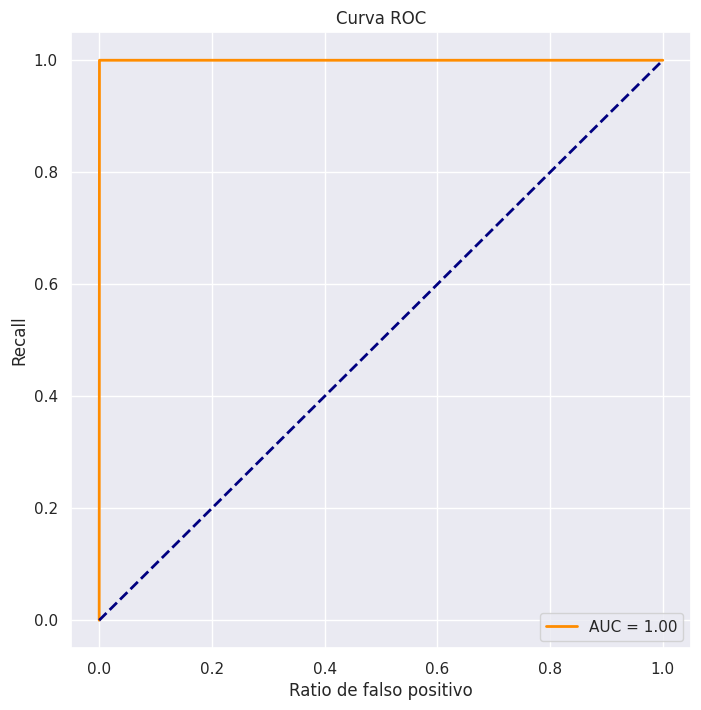

In [21]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, val_preds)

roc_auc = auc(fpr, tpr)

sns.set_theme(palette="dark")
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Ratio de falso positivo')
plt.ylabel('Recall')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

El sueño de todo Data Scientist es que sus gráficos se vean así, perfección absoluta.

Veamos ahora la matriz de confución para revisar el detalle de nuestros números

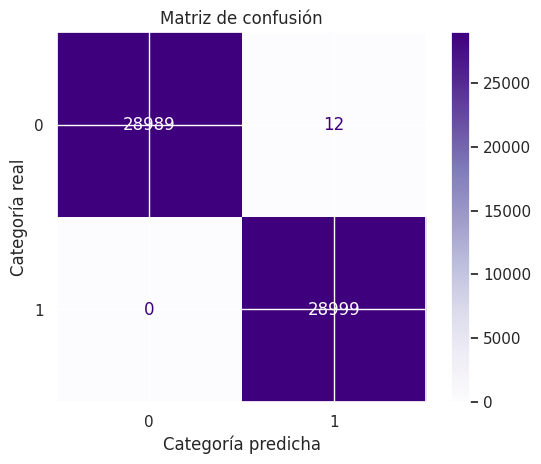

In [22]:
ConfusionMatrixDisplay.from_estimator(xgbc, X_test, y_test, cmap = 'Purples');
sns.set_theme(style="dark")
plt.title("Matriz de confusión")
plt.xlabel('Categoría predicha')
plt.ylabel('Categoría real')
plt.show();

In [23]:
print(f"El porcentaje de falsos positivos es de {round((12*100)/28999,3)}%")

El porcentaje de falsos positivos es de 0.041%


In [24]:
print(f"El porcentaje de error total es de {round((12*100)/X_test.shape[0],3)}%")

El porcentaje de error total es de 0.021%


Tenemos 12 falsos positivos, lo que equivale a el 0.041% de los positivos y ningún falso negativo. Esto nos muestra que tenemos un modelo muy potente y muy sólido para la predicción de fraudes con tarjeta de crédito, lo que permitiría fortalecer la seguridad que otorgan las entidades bancarias a sus clientes.

El error total del modelo, analizando 58000 transacciones, fueron sólo 12, equivalentes a un 0.021% del total de entradas analizadas en el conjunto de pruebas

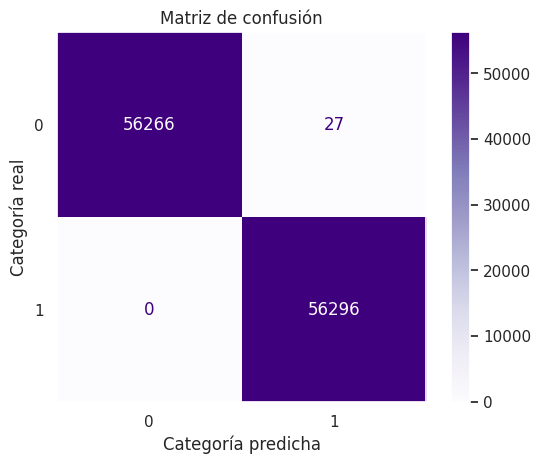

In [25]:
ConfusionMatrixDisplay.from_estimator(xgbc, X_val, y_val, cmap = 'Purples');
sns.set_theme(style="dark")
plt.title("Matriz de confusión")
plt.xlabel('Categoría predicha')
plt.ylabel('Categoría real')
plt.show();

In [26]:
print(f"El porcentaje de falsos positivos es de {round((27*100)/56296,3)}%")

El porcentaje de falsos positivos es de 0.048%


In [27]:
print(f"El porcentaje de error total es de {round((27*100)/X_val.shape[0],3)}%")

El porcentaje de error total es de 0.024%


In [28]:
X_val.shape[0]

112589

Encontramos en el set de validación que nuestros errores son más que en set de prueba, alcanzando 27 faltos positivos(0.048% de esta clase) y ningun falso negativo. Podemos ver, sin embargo, que sus porcentajes son prácticamente los mismos debido a que el conjunto de datos de validación contiene más datos que el conjunto de pruebas.

El error total de este modelo en su ronda de validación nos muestra 17 errores de 112589 datos analizados, lo que equivale a un 0.024%, confirmando lo que ya habíamos visto en los análisis anteriores y es que este modelo está perfectamente capacitado para usar estos datos para descubrir transacciones fraudulentas usando la información proporcionada

Ahora vamos a probar qué sucede si entrenamos nuestros modelos con algunas columnas de PCA en lugar de con todas.

Lo que esperamos ver es una reducción en el tiempo de procesamiento a un tercio y un aumento en los errores de clasificación, es decir, una baja en las métricas en un par de puntos porcentuales.

Veamos si esta hipótesis se cumple al utilizar las primeras 13 columnas que explican al rededor del 90% de la varianza

In [29]:
y = df["Class"]

In [30]:
X = df.iloc[:,0:13]

In [31]:
X_train, X_test, y_train, y_test=train_test_split(X, y,test_size=0.3, stratify=y, random_state=21)
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, test_size=0.66, random_state=21)

In [32]:
logreg = LogisticRegression(solver="newton-cholesky")

logreg.fit(X_train, y_train)

test_preds = logreg.predict(X_test)

test_score = accuracy_score(y_test, test_preds)

print("Reporte de clasificación para Regresor Logístico \n")
print(classification_report(y_test,test_preds))

Reporte de clasificación para Regresor Logístico 

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     29001
           1       0.97      0.93      0.95     28999

    accuracy                           0.95     58000
   macro avg       0.95      0.95      0.95     58000
weighted avg       0.95      0.95      0.95     58000




Reporte de clasificación para Regresor Logístico

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     29001
           1       0.98      0.95      0.96     28999

    accuracy                           0.96     58000
    macro avg      0.97      0.96      0.96     58000
    weighted avg   0.97      0.96      0.96     58000

Tal como esperábamos, bajamos el tiempo de ejecución de al rededor de un minuto a tres segundos con una perdida de precision de 1% y recall de 2%

In [33]:
dtc = DecisionTreeClassifier(max_depth=9)

dtc.fit(X_train, y_train)

test_preds = dtc.predict(X_test)

test_score = accuracy_score(y_test, test_preds)

print("Reporte de clasificación para DecisionTreeClassifier \n")
print(classification_report(y_test,test_preds))

Reporte de clasificación para DecisionTreeClassifier 

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     29001
           1       0.98      0.97      0.98     28999

    accuracy                           0.98     58000
   macro avg       0.98      0.98      0.98     58000
weighted avg       0.98      0.98      0.98     58000



26 s


output
Reporte de clasificación para DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     29001
           1       0.98      0.98      0.98     28999

    accuracy                           0.98     58000
    macro avg      0.98      0.98      0.98     58000
    weighted avg   0.98      0.98      0.98     58000

Esta vez bajamos el tiempo de 26 segundos a 9 segundos sin cambios en la métrica. Este es un resultado mejor que lo esperado

In [34]:
rfc = RandomForestClassifier(n_estimators=21, max_depth=7)

rfc.fit(X_train, y_train)

test_preds = rfc.predict(X_test)

test_score = accuracy_score(y_test, test_preds)

print("Reporte de clasificación para RandomForestClassifier \n")
print(classification_report(y_test,test_preds))

Reporte de clasificación para RandomForestClassifier 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29001
           1       0.99      0.94      0.97     28999

    accuracy                           0.97     58000
   macro avg       0.97      0.97      0.97     58000
weighted avg       0.97      0.97      0.97     58000



In [35]:
svc = SVC()

svc.fit(X_train, y_train)

test_preds = svc.predict(X_test)

test_score = accuracy_score(y_test, test_preds)

print("Reporte de clasificación para Support Vector Machines \n")
print(classification_report(y_test,test_preds))

Reporte de clasificación para Support Vector Machines 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     29001
           1       0.99      0.98      0.98     28999

    accuracy                           0.98     58000
   macro avg       0.98      0.98      0.98     58000
weighted avg       0.98      0.98      0.98     58000



Para este modelo no tenemos datos anteriores para comparar pero sí podemos compara el tiempo y bajó de 2 horas y 30 minutos a sólo 31 minutos

In [36]:
knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train, y_train)

test_preds = knn.predict(X_test)

test_score = accuracy_score(y_test, test_preds)

print("Reporte de clasificación para k-Nearest Neighbors \n")
print(classification_report(y_test,test_preds))

Reporte de clasificación para k-Nearest Neighbors 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     29001
           1       0.99      1.00      1.00     28999

    accuracy                           1.00     58000
   macro avg       1.00      1.00      1.00     58000
weighted avg       1.00      1.00      1.00     58000



Este modelo subió sus métricas de ser las más bajas a las más altas. Puntuación casi perfecta en precision y recall, también bajó el tiempo de ejecución a la mitad

In [37]:
xgbc = xgb.XGBClassifier(n_estimators=432, max_depth=11)

xgbc.fit(X_train, y_train)

test_preds = xgbc.predict(X_test)

test_score = accuracy_score(y_test, test_preds)

print("Reporte de clasificación para Gradient Boosting  \n")
print(classification_report(y_test,test_preds))

Reporte de clasificación para Gradient Boosting  

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29001
           1       1.00      1.00      1.00     28999

    accuracy                           1.00     58000
   macro avg       1.00      1.00      1.00     58000
weighted avg       1.00      1.00      1.00     58000



XGB Classifier tomó el mismo tiempo de cómputo y volvió a lograr resultados perfectos. Veamos ahora la matriz de confusión los detalles bajo el puntaje perfecto de estas métricas

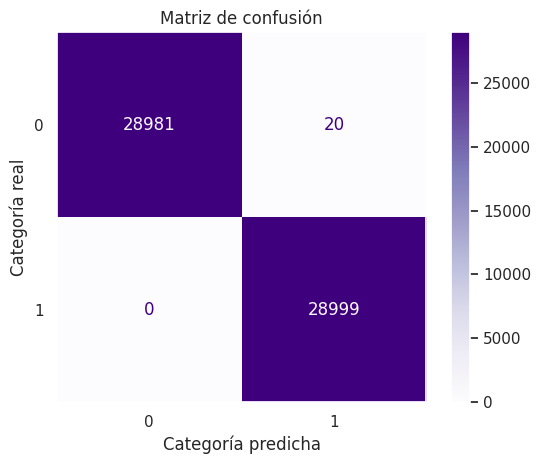

In [38]:
ConfusionMatrixDisplay.from_estimator(xgbc, X_test, y_test, cmap = 'Purples');
sns.set_theme(style="dark")
plt.title("Matriz de confusión")
plt.xlabel('Categoría predicha')
plt.ylabel('Categoría real')
plt.show();

Podemos ver que tuvimos un aumento de falsos positivos de 12 a 20, casi el doble y si consideramos que no obtuvimos ninguna ganancia en tiempo de cómputo con este modelo, podemos concluir que en este caso no tiene ningún sentido la reducción de dimensionalidad.

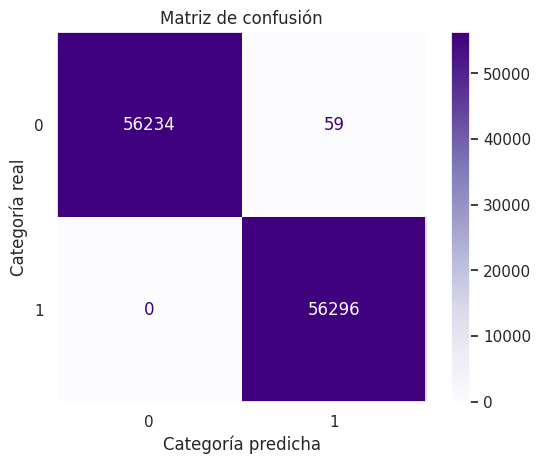

In [39]:
ConfusionMatrixDisplay.from_estimator(xgbc, X_val, y_val, cmap = 'Purples');
sns.set_theme(style="dark")
plt.title("Matriz de confusión")
plt.xlabel('Categoría predicha')
plt.ylabel('Categoría real')
plt.show();

Nuevamente vemos el mismo resultado, un aumento de los falsos positivos de 27 a 59, en este caso un aumento aún mayor, más del doble. Esto termina de confirmar lo que ya habíamos concluido y es que para este problema nos funciona mejor el modelo XGB classifier con todas las columnas, ya que genera mejores resultados y en el mismo tiempo de cómputo.

A continuación vamos a usar redes neuronales para resolver este problema y comparar resultados con los modelos de Machine Learning y para esto volveremos a cargar los datos e importaremos tensorflow

In [40]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [41]:
file= "/content/drive/MyDrive/Data Sets/creditcard_2023.csv"
df= pd.read_csv(file, index_col="id")

In [42]:
X=df.drop(columns="Class")
y=df["Class"]
X_train, X_test, y_train, y_test=train_test_split(X, y,test_size=0.3, stratify=y, random_state=21)
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, test_size=0.66, random_state=21)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(950, activation='relu'))
model.add(tf.keras.layers.Dense(900, activation='relu'))
model.add(tf.keras.layers.Dense(850, activation='relu'))
model.add(tf.keras.layers.Dense(800, activation='relu'))
model.add(tf.keras.layers.Dense(750, activation='relu'))
model.add(tf.keras.layers.Dense(700, activation='relu'))
model.add(tf.keras.layers.Dense(650, activation='relu'))
model.add(tf.keras.layers.Dense(600, activation='relu'))
model.add(tf.keras.layers.Dense(550, activation='relu'))
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dense(450, activation='relu'))
model.add(tf.keras.layers.Dense(400, activation='relu'))
model.add(tf.keras.layers.Dense(350, activation='relu'))
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(tf.keras.layers.Dense(250, activation='relu'))
model.add(tf.keras.layers.Dense(200, activation='relu'))
model.add(tf.keras.layers.Dense(150, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["AUC","Precision","Recall",
                       "TruePositives","TrueNegatives",
                       "FalsePositives","FalseNegatives"])

history = model.fit(X_train, y_train, epochs=30, batch_size=3333,
                    validation_data=(X_val, y_val))


Este modelo de redes neuronales tomó 2 horas y 36 minutos en ejecutar

In [43]:
#model.summary()

=================================================================
Total params: 6689551 (25.52 MB)
Trainable params: 6689551 (25.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

In [44]:
#print("Evaluate")
#result = model.evaluate(X_test,y_test)
#dict(zip(model.metrics_names, result))

print("Evaluate")
result = model.evaluate(X_test,y_test)
dict(zip(model.metrics_names, result))


Evaluate
1813/1813 [==============================] - 40s 22ms/step - loss: 0.6931 - auc: 0.5019 - precision: 0.5022 - recall: 0.8398 - true_positives: 24354.0000 - true_negatives: 4860.0000 - false_positives: 24141.0000 - false_negatives: 4645.0000
{'loss': 0.6931266784667969,
 'auc': 0.5019461512565613,
 'precision': 0.5021960735321045,
 'recall': 0.8398220539093018,
 'true_positives': 24354.0,
 'true_negatives': 4860.0,
 'false_positives': 24141.0,
 'false_negatives': 4645.0}

Estos números no son los mejores, vamos a ver nuestra matriz de confusión

In [45]:
#y_hat = model.predict(X_test)

In [46]:
#y_hat = y_hat.flatten()
#y_hat = pd.Series(y_hat)

In [47]:
#y_hat = y_hat.round(0)

ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_hat);
sns.set_theme(style="darkgrid")
plt.title("Matriz de confusión")
plt.xlabel('Categoría predicha')
plt.ylabel('Categoría real')
plt.show();



4860.........24141
.                 
.                  
.                 
.               
.                 
4645.........24354





Podemos observar claramente que nuestros resultados no son óptimos. Vamos a visualizar la pérdida a ver si encontramos que nuestro modelo presenta over fitting

In [48]:
# Visualizar la perdida
#plt.plot(history.history['loss'], label='Train loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.legend();

Podemos ver que la pérdida de validación y la pérdida de entrenamiento son muy similares y muy estables, con algunos picos de train loss en epochs 10, 19 y 25. Vamos a cambiar la capa de entrada para que se ajuste a la cantidad de columnas y vamos a aumentar la cantidad de epochs para generar mejores resultados. También vamos a aumentar la cantidad de capas para generar un decenso de una neurona por capa hasta llegar a la capa de salida

In [49]:
X_test.shape[1]

29

In [50]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(29, activation='relu'))
model.add(tf.keras.layers.Dense(28, activation='relu'))
model.add(tf.keras.layers.Dense(27, activation='relu'))
model.add(tf.keras.layers.Dense(26, activation='relu'))
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(23, activation='relu'))
model.add(tf.keras.layers.Dense(22, activation='relu'))
model.add(tf.keras.layers.Dense(21, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='relu'))
model.add(tf.keras.layers.Dense(19, activation='relu'))
model.add(tf.keras.layers.Dense(18, activation='relu'))
model.add(tf.keras.layers.Dense(17, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(14, activation='relu'))
model.add(tf.keras.layers.Dense(13, activation='relu'))
model.add(tf.keras.layers.Dense(12, activation='relu'))
model.add(tf.keras.layers.Dense(11, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(9, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(7, activation='relu'))
model.add(tf.keras.layers.Dense(6, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["AUC","Precision","Recall",
                       "TruePositives","TrueNegatives",
                       "FalsePositives","FalseNegatives"])

history = model.fit(X_train, y_train, epochs=90, batch_size=3875,
                    validation_data=(X_val, y_val))

Epoch 1/90
103/103 [==============================] - 7s 21ms/step - loss: 0.6931 - auc: 0.5000 - precision: 0.4993 - recall: 0.3764 - true_positives: 74915.0000 - true_negatives: 123895.0000 - false_positives: 75126.0000 - false_negatives: 124105.0000 - val_loss: 0.6931 - val_auc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_true_positives: 56296.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 56293.0000 - val_false_negatives: 0.0000e+00
Epoch 2/90
103/103 [==============================] - 1s 14ms/step - loss: 0.6932 - auc: 0.5000 - precision: 0.4979 - recall: 0.5789 - true_positives: 115216.0000 - true_negatives: 82821.0000 - false_positives: 116200.0000 - false_negatives: 83804.0000 - val_loss: 0.6931 - val_auc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_true_positives: 56296.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 56293.0000 - val_false_negatives: 0.0000e+00
Epoch 3/90
103/103 [==============================] - 1s 14ms/

Este nuevo modelo construido a partir de las normas o buenas prácticas de deeplearning se ha ejecutado en 4 minutos y 36 segundos

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                870       
                                                                 
 dense_1 (Dense)             (None, 28)                840       
                                                                 
 dense_2 (Dense)             (None, 27)                783       
                                                                 
 dense_3 (Dense)             (None, 26)                728       
                                                                 
 dense_4 (Dense)             (None, 25)                675       
                                                                 
 dense_5 (Dense)             (None, 24)                624       
                                                                 
 dense_6 (Dense)             (None, 23)                5

In [52]:
print("Evaluate")
result = model.evaluate(X_test,y_test)
dict(zip(model.metrics_names, result))

Evaluate
1813/1813 [==============================] - 3s 1ms/step - loss: 0.6931 - auc: 0.5000 - precision: 0.5000 - recall: 1.0000 - true_positives: 28999.0000 - true_negatives: 0.0000e+00 - false_positives: 29001.0000 - false_negatives: 0.0000e+00


{'loss': 0.6931463479995728,
 'auc': 0.5,
 'precision': 0.4999827444553375,
 'recall': 1.0,
 'true_positives': 28999.0,
 'true_negatives': 0.0,
 'false_positives': 29001.0,
 'false_negatives': 0.0}

Ya podemos ver aquí que con un mucho menor costo computacional tenemos resultados mucho mejores. Tenemos recall perfecto mientras que nuestra métrica de precision y loss aún pueden ser mejoradas

In [53]:
y_hat = model.predict(X_test)

1813/1813 [==============================] - 2s 1ms/step


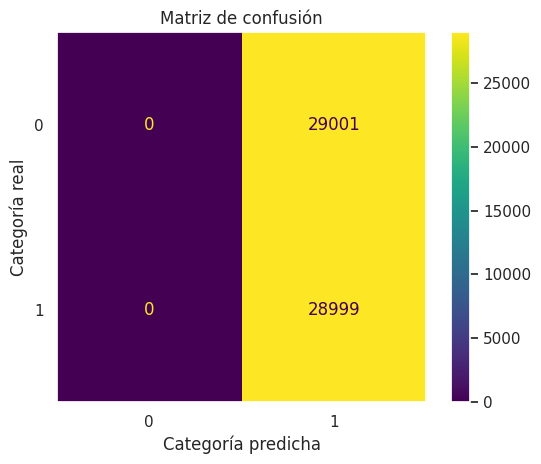

In [54]:
y_hat = y_hat.flatten()
y_hat = pd.Series(y_hat)
y_hat = y_hat.round(0)

ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_hat);
sns.set_theme(style="dark", palette="dark")
plt.title("Matriz de confusión")
plt.xlabel('Categoría predicha')
plt.ylabel('Categoría real')
plt.show();

Podemos ver que tnemos mejores resultados que con nuestra primera red. Ahora vamos a ejecutar algunas pruebas para ver cómo mejorar este modelo que como bsae ya está mejor

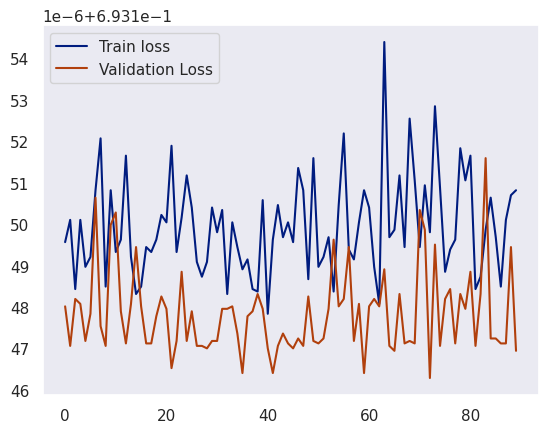

In [55]:
# Visualizar la perdida
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

Vemos que se ve muy bien nuestra relación entre la pérdida de entrenamiento y la de validación.

Vamos a hacer algunos cambios al modelo y ver qué resultados nos entrega

In [56]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(29, activation='tanh'))
model.add(tf.keras.layers.Dense(28, activation='tanh'))
model.add(tf.keras.layers.Dense(27, activation='tanh'))
model.add(tf.keras.layers.Dense(26, activation='tanh'))
model.add(tf.keras.layers.Dense(25, activation='tanh'))
model.add(tf.keras.layers.Dense(24, activation='tanh'))
model.add(tf.keras.layers.Dense(23, activation='tanh'))
model.add(tf.keras.layers.Dense(22, activation='tanh'))
model.add(tf.keras.layers.Dense(21, activation='tanh'))
model.add(tf.keras.layers.Dense(20, activation='tanh'))
model.add(tf.keras.layers.Dense(19, activation='tanh'))
model.add(tf.keras.layers.Dense(18, activation='tanh'))
model.add(tf.keras.layers.Dense(17, activation='tanh'))
model.add(tf.keras.layers.Dense(16, activation='tanh'))
model.add(tf.keras.layers.Dense(15, activation='tanh'))
model.add(tf.keras.layers.Dense(14, activation='tanh'))
model.add(tf.keras.layers.Dense(13, activation='tanh'))
model.add(tf.keras.layers.Dense(12, activation='tanh'))
model.add(tf.keras.layers.Dense(11, activation='tanh'))
model.add(tf.keras.layers.Dense(10, activation='tanh'))
model.add(tf.keras.layers.Dense(9, activation='tanh'))
model.add(tf.keras.layers.Dense(8, activation='tanh'))
model.add(tf.keras.layers.Dense(7, activation='tanh'))
model.add(tf.keras.layers.Dense(6, activation='tanh'))
model.add(tf.keras.layers.Dense(5, activation='tanh'))
model.add(tf.keras.layers.Dense(4, activation='tanh'))
model.add(tf.keras.layers.Dense(3, activation='tanh'))
model.add(tf.keras.layers.Dense(2, activation='tanh'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["AUC","Precision","Recall",
                       "TruePositives","TrueNegatives",
                       "FalsePositives","FalseNegatives"])

history = model.fit(X_train, y_train, epochs=90, batch_size=3875,
                    validation_data=(X_val, y_val))

Epoch 1/90
103/103 [==============================] - 7s 30ms/step - loss: 0.6923 - auc: 0.5173 - precision: 0.5098 - recall: 0.6464 - true_positives: 128638.0000 - true_negatives: 75307.0000 - false_positives: 123714.0000 - false_negatives: 70382.0000 - val_loss: 0.6926 - val_auc: 0.5056 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 56293.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 56296.0000
Epoch 2/90
103/103 [==============================] - 2s 16ms/step - loss: 0.6940 - auc: 0.5060 - precision: 0.5052 - recall: 0.4553 - true_positives: 90611.0000 - true_negatives: 110280.0000 - false_positives: 88741.0000 - false_negatives: 108409.0000 - val_loss: 0.6932 - val_auc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_true_positives: 56296.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 56293.0000 - val_false_negatives: 0.0000e+00
Epoch 3/90
103/103 [==============================] - 

Este modelo tomó 5 minutos y 24 segundos

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 29)                870       
                                                                 
 dense_30 (Dense)            (None, 28)                840       
                                                                 
 dense_31 (Dense)            (None, 27)                783       
                                                                 
 dense_32 (Dense)            (None, 26)                728       
                                                                 
 dense_33 (Dense)            (None, 25)                675       
                                                                 
 dense_34 (Dense)            (None, 24)                624       
                                                                 
 dense_35 (Dense)            (None, 23)               

In [58]:
print("Evaluate")
result = model.evaluate(X_test,y_test)
dict(zip(model.metrics_names, result))

Evaluate
1813/1813 [==============================] - 3s 2ms/step - loss: 0.6931 - auc: 0.5000 - precision: 0.5000 - recall: 1.0000 - true_positives: 28999.0000 - true_negatives: 0.0000e+00 - false_positives: 29001.0000 - false_negatives: 0.0000e+00


{'loss': 0.6931458711624146,
 'auc': 0.5,
 'precision': 0.4999827444553375,
 'recall': 1.0,
 'true_positives': 28999.0,
 'true_negatives': 0.0,
 'false_positives': 29001.0,
 'false_negatives': 0.0}

Estas métricas son casi iguales a las obtenidas con el modelo anterior

In [59]:
y_hat = model.predict(X_test)

1813/1813 [==============================] - 2s 1ms/step


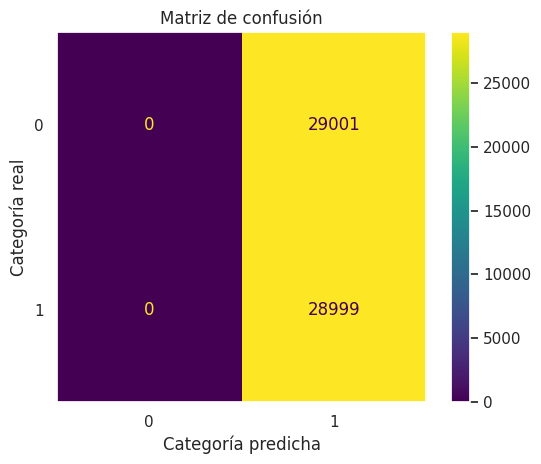

In [60]:
y_hat = y_hat.flatten()
y_hat = pd.Series(y_hat)
y_hat = y_hat.round(0)

ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_hat);
sns.set_theme(style="dark", palette="dark")
plt.title("Matriz de confusión")
plt.xlabel('Categoría predicha')
plt.ylabel('Categoría real')
plt.show();

Vemos la misma matriz de confusión, seguimos avanzando con las pruebas

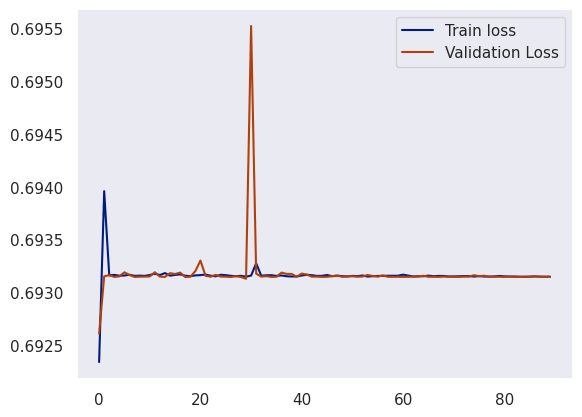

In [61]:
# Visualizar la perdida
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

Se ve un poco caótico el comienzo sin embargo vemos que se logra estabilizar la relación entre la pérdida de entrenamiento y la de validación

In [62]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(29, activation='elu'))
model.add(tf.keras.layers.Dense(28, activation='elu'))
model.add(tf.keras.layers.Dense(27, activation='elu'))
model.add(tf.keras.layers.Dense(26, activation='elu'))
model.add(tf.keras.layers.Dense(25, activation='elu'))
model.add(tf.keras.layers.Dense(24, activation='elu'))
model.add(tf.keras.layers.Dense(23, activation='elu'))
model.add(tf.keras.layers.Dense(22, activation='elu'))
model.add(tf.keras.layers.Dense(21, activation='elu'))
model.add(tf.keras.layers.Dense(20, activation='elu'))
model.add(tf.keras.layers.Dense(19, activation='elu'))
model.add(tf.keras.layers.Dense(18, activation='elu'))
model.add(tf.keras.layers.Dense(17, activation='elu'))
model.add(tf.keras.layers.Dense(16, activation='elu'))
model.add(tf.keras.layers.Dense(15, activation='elu'))
model.add(tf.keras.layers.Dense(14, activation='elu'))
model.add(tf.keras.layers.Dense(13, activation='elu'))
model.add(tf.keras.layers.Dense(12, activation='elu'))
model.add(tf.keras.layers.Dense(11, activation='elu'))
model.add(tf.keras.layers.Dense(10, activation='elu'))
model.add(tf.keras.layers.Dense(9, activation='elu'))
model.add(tf.keras.layers.Dense(8, activation='elu'))
model.add(tf.keras.layers.Dense(7, activation='elu'))
model.add(tf.keras.layers.Dense(6, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='elu'))
model.add(tf.keras.layers.Dense(4, activation='elu'))
model.add(tf.keras.layers.Dense(3, activation='elu'))
model.add(tf.keras.layers.Dense(2, activation='elu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["AUC","Precision","Recall",
                       "TruePositives","TrueNegatives",
                       "FalsePositives","FalseNegatives"])

history = model.fit(X_train, y_train, epochs=90, batch_size=3875,
                    validation_data=(X_val, y_val))

Epoch 1/90
103/103 [==============================] - 8s 34ms/step - loss: 0.6934 - auc: 0.5004 - precision: 0.4999 - recall: 0.4664 - true_positives: 92820.0000 - true_negatives: 106169.0000 - false_positives: 92852.0000 - false_negatives: 106200.0000 - val_loss: 0.6931 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 56293.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 56296.0000
Epoch 2/90
103/103 [==============================] - 2s 22ms/step - loss: 0.6931 - auc: 0.5068 - precision: 0.5039 - recall: 0.4582 - true_positives: 91186.0000 - true_negatives: 109252.0000 - false_positives: 89769.0000 - false_negatives: 107834.0000 - val_loss: 0.6932 - val_auc: 0.5018 - val_precision: 0.4995 - val_recall: 0.1574 - val_true_positives: 8860.0000 - val_true_negatives: 47414.0000 - val_false_positives: 8879.0000 - val_false_negatives: 47436.0000
Epoch 3/90
103/103 [==============================] - 2s

Este modelo tómo 8 minutos y 32 segundos en ejecutar

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 29)                870       
                                                                 
 dense_59 (Dense)            (None, 28)                840       
                                                                 
 dense_60 (Dense)            (None, 27)                783       
                                                                 
 dense_61 (Dense)            (None, 26)                728       
                                                                 
 dense_62 (Dense)            (None, 25)                675       
                                                                 
 dense_63 (Dense)            (None, 24)                624       
                                                                 
 dense_64 (Dense)            (None, 23)               

In [64]:
print("Evaluate")
result = model.evaluate(X_test,y_test)
dict(zip(model.metrics_names, result))

Evaluate
1813/1813 [==============================] - 3s 2ms/step - loss: 0.2272 - auc: 0.9682 - precision: 0.9997 - recall: 0.8294 - true_positives: 24052.0000 - true_negatives: 28994.0000 - false_positives: 7.0000 - false_negatives: 4947.0000


{'loss': 0.22724801301956177,
 'auc': 0.9682379961013794,
 'precision': 0.9997090697288513,
 'recall': 0.8294079303741455,
 'true_positives': 24052.0,
 'true_negatives': 28994.0,
 'false_positives': 7.0,
 'false_negatives': 4947.0}

Podemos ver que nuestras métricas tuvieron una mejora tremenda! La pérdida bajó muchísimo, subió nuestro AUC, la preción casi se dobló llegando casi al 100% y tuvimos una baja de 5% en recall. Este es un modelo que podemos elegir como base para seguir ajustando otros hiperparámetros

In [65]:
y_hat = model.predict(X_test)

1813/1813 [==============================] - 3s 1ms/step


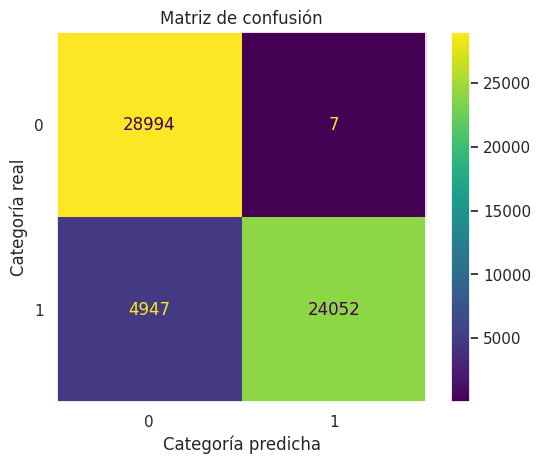

In [66]:
y_hat = y_hat.flatten()
y_hat = pd.Series(y_hat)
y_hat = y_hat.round(0)

ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_hat);
sns.set_theme(style="dark", palette="dark")
plt.title("Matriz de confusión")
plt.xlabel('Categoría predicha')
plt.ylabel('Categoría real')
plt.show();

Vemos que nuestra matriz de confusión nos muestra resultados muchísimo más favorables

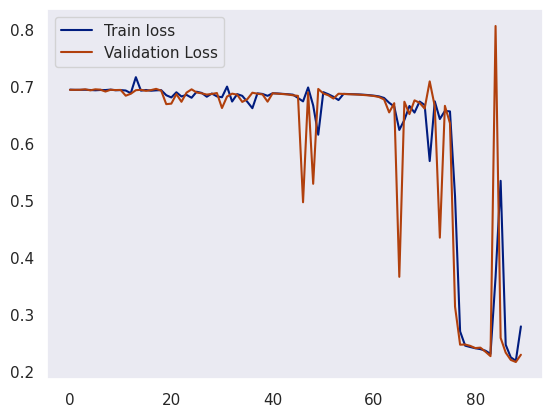

In [67]:
# Visualizar la perdida
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

Aquí se observa un comienzo parejo a la altura de 0.7, lo mismo que habímos visto en los otros modelos. Sin embargo, en el intervalo de epochs (40,60) podemos observar que hay un poco de caos y luego hay una disminución constante de la pérdida. A este modelo en particular parece una buena idea aumentarle el número de epochs

In [68]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(29, input_dim = 29,
                                    activation='elu'))
model.add(tf.keras.layers.Dense(28, activation='elu'))
model.add(tf.keras.layers.Dense(27, activation='elu'))
model.add(tf.keras.layers.Dense(26, activation='elu'))
model.add(tf.keras.layers.Dense(25, activation='elu'))
model.add(tf.keras.layers.Dense(24, activation='elu'))
model.add(tf.keras.layers.Dense(23, activation='elu'))
model.add(tf.keras.layers.Dense(22, activation='elu'))
model.add(tf.keras.layers.Dense(21, activation='elu'))
model.add(tf.keras.layers.Dense(20, activation='elu'))
model.add(tf.keras.layers.Dense(19, activation='elu'))
model.add(tf.keras.layers.Dense(18, activation='elu'))
model.add(tf.keras.layers.Dense(17, activation='elu'))
model.add(tf.keras.layers.Dense(16, activation='elu'))
model.add(tf.keras.layers.Dense(15, activation='elu'))
model.add(tf.keras.layers.Dense(14, activation='elu'))
model.add(tf.keras.layers.Dense(13, activation='elu'))
model.add(tf.keras.layers.Dense(12, activation='elu'))
model.add(tf.keras.layers.Dense(11, activation='elu'))
model.add(tf.keras.layers.Dense(10, activation='elu'))
model.add(tf.keras.layers.Dense(9, activation='elu'))
model.add(tf.keras.layers.Dense(8, activation='elu'))
model.add(tf.keras.layers.Dense(7, activation='elu'))
model.add(tf.keras.layers.Dense(6, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='elu'))
model.add(tf.keras.layers.Dense(4, activation='elu'))
model.add(tf.keras.layers.Dense(3, activation='elu'))
model.add(tf.keras.layers.Dense(2, activation='elu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["AUC","Precision","Recall",
                       "TruePositives","TrueNegatives",
                       "FalsePositives","FalseNegatives"])

history = model.fit(X_train, y_train, epochs=120, batch_size=3875,
                    validation_data=(X_val, y_val))

Epoch 1/120
103/103 [==============================] - 6s 27ms/step - loss: 0.6926 - auc: 0.5135 - precision: 0.5093 - recall: 0.5067 - true_positives: 100836.0000 - true_negatives: 101862.0000 - false_positives: 97159.0000 - false_negatives: 98184.0000 - val_loss: 0.6922 - val_auc: 0.5133 - val_precision: 0.5118 - val_recall: 0.3339 - val_true_positives: 18798.0000 - val_true_negatives: 38361.0000 - val_false_positives: 17932.0000 - val_false_negatives: 37498.0000
Epoch 2/120
103/103 [==============================] - 3s 28ms/step - loss: 0.6910 - auc: 0.5335 - precision: 0.5187 - recall: 0.6299 - true_positives: 125370.0000 - true_negatives: 82674.0000 - false_positives: 116347.0000 - false_negatives: 73650.0000 - val_loss: 0.6793 - val_auc: 0.8938 - val_precision: 0.9992 - val_recall: 0.2555 - val_true_positives: 14384.0000 - val_true_negatives: 56282.0000 - val_false_positives: 11.0000 - val_false_negatives: 41912.0000
Epoch 3/120
103/103 [==============================] - 3s 25ms/

Este modelo tardó 10 minutos y 30 segundos en ejecutar

In [69]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 29)                870       
                                                                 
 dense_88 (Dense)            (None, 28)                840       
                                                                 
 dense_89 (Dense)            (None, 27)                783       
                                                                 
 dense_90 (Dense)            (None, 26)                728       
                                                                 
 dense_91 (Dense)            (None, 25)                675       
                                                                 
 dense_92 (Dense)            (None, 24)                624       
                                                                 
 dense_93 (Dense)            (None, 23)               

In [70]:
print("Evaluate")
result = model.evaluate(X_test,y_test)
dict(zip(model.metrics_names, result))

Evaluate
1813/1813 [==============================] - 3s 2ms/step - loss: 0.1834 - auc: 0.9785 - precision: 0.9938 - recall: 0.8832 - true_positives: 25613.0000 - true_negatives: 28841.0000 - false_positives: 160.0000 - false_negatives: 3386.0000


{'loss': 0.18343548476696014,
 'auc': 0.9784863591194153,
 'precision': 0.993791937828064,
 'recall': 0.883237361907959,
 'true_positives': 25613.0,
 'true_negatives': 28841.0,
 'false_positives': 160.0,
 'false_negatives': 3386.0}

Tenemos buenas métricas aunque podemos ver un aumento en lo falsos negativos y una baja en recall, sin embargo una disminusión en los falsos positivos y aumento de precision

In [71]:
y_hat = model.predict(X_test)

1813/1813 [==============================] - 3s 1ms/step


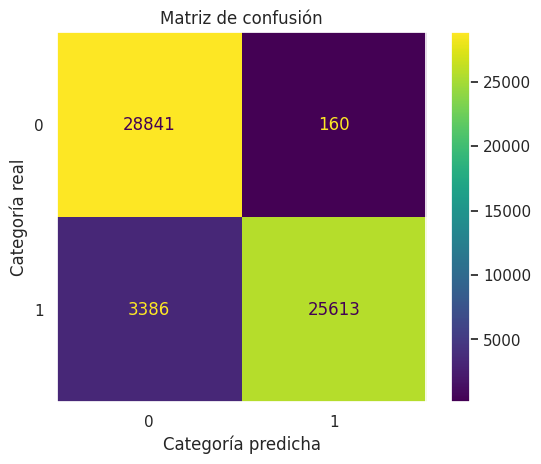

In [72]:
y_hat = y_hat.flatten()
y_hat = pd.Series(y_hat)
y_hat = y_hat.round(0)

ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_hat);
sns.set_theme(style="dark", palette="dark")
plt.title("Matriz de confusión")
plt.xlabel('Categoría predicha')
plt.ylabel('Categoría real')
plt.show();

Podemos ver en esta matriz de confución que mejoramos la capacidad de precedir las transacciones normales y perdimos capacidad de predecir transacciones fraudulentas

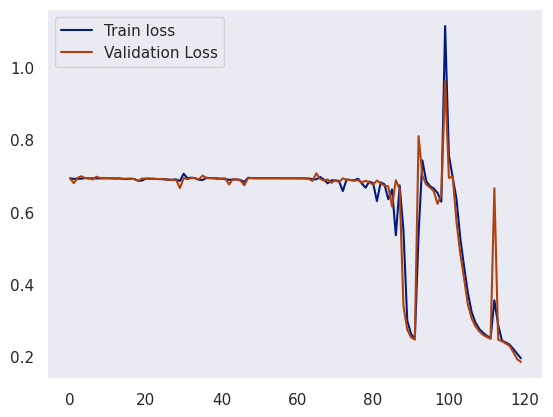

In [73]:
# Visualizar la perdida
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

Vemos que sobre las 90 epochs hay una tendencia constante a la baja y justo antes de la última epch hay unos picos de pérdida de entrenamiento y validación. Vamos a aumentar aún más el número de epochs

In [80]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(29, input_dim = 29,
                                    activation='elu'))
model.add(tf.keras.layers.Dense(28, activation='elu'))
model.add(tf.keras.layers.Dense(27, activation='elu'))
model.add(tf.keras.layers.Dense(26, activation='elu'))
model.add(tf.keras.layers.Dense(25, activation='elu'))
model.add(tf.keras.layers.Dense(24, activation='elu'))
model.add(tf.keras.layers.Dense(23, activation='elu'))
model.add(tf.keras.layers.Dense(22, activation='elu'))
model.add(tf.keras.layers.Dense(21, activation='elu'))
model.add(tf.keras.layers.Dense(20, activation='elu'))
model.add(tf.keras.layers.Dense(19, activation='elu'))
model.add(tf.keras.layers.Dense(18, activation='elu'))
model.add(tf.keras.layers.Dense(17, activation='elu'))
model.add(tf.keras.layers.Dense(16, activation='elu'))
model.add(tf.keras.layers.Dense(15, activation='elu'))
model.add(tf.keras.layers.Dense(14, activation='elu'))
model.add(tf.keras.layers.Dense(13, activation='elu'))
model.add(tf.keras.layers.Dense(12, activation='elu'))
model.add(tf.keras.layers.Dense(11, activation='elu'))
model.add(tf.keras.layers.Dense(10, activation='elu'))
model.add(tf.keras.layers.Dense(9, activation='elu'))
model.add(tf.keras.layers.Dense(8, activation='elu'))
model.add(tf.keras.layers.Dense(7, activation='elu'))
model.add(tf.keras.layers.Dense(6, activation='elu'))
model.add(tf.keras.layers.Dense(5, activation='elu'))
model.add(tf.keras.layers.Dense(4, activation='elu'))
model.add(tf.keras.layers.Dense(3, activation='elu'))
model.add(tf.keras.layers.Dense(2, activation='elu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["AUC","Precision","Recall",
                       "TruePositives","TrueNegatives",
                       "FalsePositives","FalseNegatives"])

history = model.fit(X_train, y_train, epochs=150, batch_size=3875,
                    validation_data=(X_val, y_val))

Epoch 1/150
103/103 [==============================] - 15s 65ms/step - loss: 0.6932 - auc: 0.5014 - precision: 0.5010 - recall: 0.4445 - true_positives: 88464.0000 - true_negatives: 110912.0000 - false_positives: 88109.0000 - false_negatives: 110556.0000 - val_loss: 0.6932 - val_auc: 0.5002 - val_precision: 0.5054 - val_recall: 8.3487e-04 - val_true_positives: 47.0000 - val_true_negatives: 56247.0000 - val_false_positives: 46.0000 - val_false_negatives: 56249.0000
Epoch 2/150
103/103 [==============================] - 2s 22ms/step - loss: 0.6928 - auc: 0.5068 - precision: 0.5037 - recall: 0.4174 - true_positives: 83069.0000 - true_negatives: 117170.0000 - false_positives: 81851.0000 - false_negatives: 115951.0000 - val_loss: 0.6930 - val_auc: 0.5020 - val_precision: 0.5000 - val_recall: 0.9862 - val_true_positives: 55521.0000 - val_true_negatives: 778.0000 - val_false_positives: 55515.0000 - val_false_negatives: 775.0000
Epoch 3/150
103/103 [==============================] - 2s 22ms/st

In [81]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_145 (Dense)           (None, 29)                870       
                                                                 
 dense_146 (Dense)           (None, 28)                840       
                                                                 
 dense_147 (Dense)           (None, 27)                783       
                                                                 
 dense_148 (Dense)           (None, 26)                728       
                                                                 
 dense_149 (Dense)           (None, 25)                675       
                                                                 
 dense_150 (Dense)           (None, 24)                624       
                                                                 
 dense_151 (Dense)           (None, 23)               

In [82]:
print("Evaluate")
result = model.evaluate(X_test,y_test)
dict(zip(model.metrics_names, result))

Evaluate
1813/1813 [==============================] - 3s 2ms/step - loss: 0.4237 - auc: 0.8361 - precision: 0.9999 - recall: 0.6095 - true_positives: 17674.0000 - true_negatives: 28999.0000 - false_positives: 2.0000 - false_negatives: 11325.0000


{'loss': 0.4236735701560974,
 'auc': 0.836078405380249,
 'precision': 0.9998868703842163,
 'recall': 0.6094692945480347,
 'true_positives': 17674.0,
 'true_negatives': 28999.0,
 'false_positives': 2.0,
 'false_negatives': 11325.0}

Podemos ver en nuestras métricas que tenemos una baja pérdida, bajamos mucho los falsos positivos pero bajamos también el recall y aumentaron muchísimo los falsos negativos. Es por este motivo que vamos a agregar regularización a nuestro modelo

In [83]:
y_hat = model.predict(X_test)

1813/1813 [==============================] - 2s 1ms/step


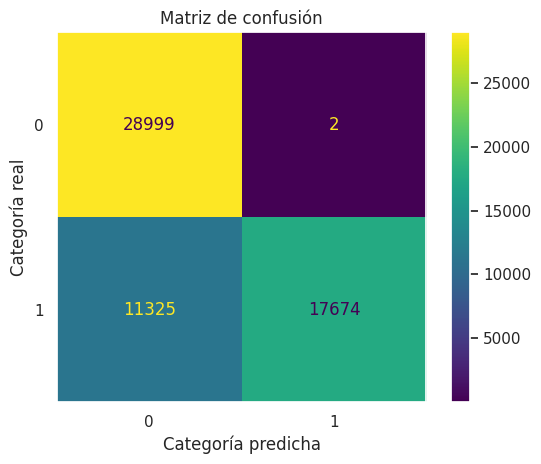

In [84]:
y_hat = y_hat.flatten()
y_hat = pd.Series(y_hat)
y_hat = y_hat.round(0)

ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_hat);
sns.set_theme(style="dark", palette="dark")
plt.title("Matriz de confusión")
plt.xlabel('Categoría predicha')
plt.ylabel('Categoría real')
plt.show();

Para la categoría 0 tuvimos un muy buen comportamiento, realmente así queremos que funcione el modelo para ambas categorías. Es por esto que avanzaremos buscando mejorar los resultados

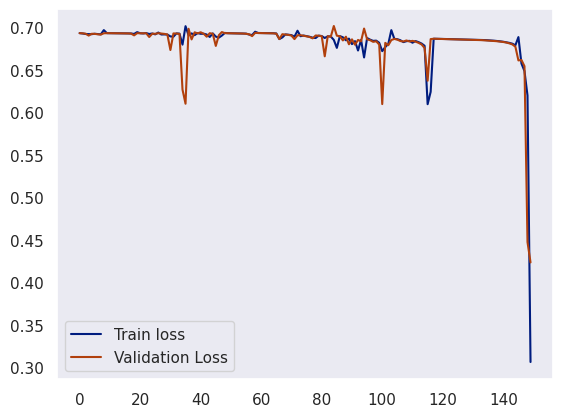

In [85]:
# Visualizar la perdida
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

Se ve que tenemos un modelo que sólo hacia el final tuvo una baja importante en las pérdidas, por lo que vamos a aumentar las epochs y también vamos a incluir dropout como regularización